## Two-dimensional GPs with PriorVAE

This notebook showcases the usage of PriorVAE on a Gaussian process dataset which is generated using a Matern52 kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp
from flax import linen as nn

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import Matern52
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL
from priorCVAE.utility import save_model_params, load_model_params

import jax.config as config
config.update("jax_enable_x64", True)

In [2]:
# Configuration dictionary
args = {
        "conditional": False,

        # data
        "x_dim": 2,
        "n_data": 25,
        
        # architecture
        "input_dim" : 625,
        "hidden_dim": 60,
        "activation_fn": nn.leaky_relu,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 2000,
        "learning_rate": 1e-3,
        "vae_var": 1.,
       }

### Generate data and train a model


In [3]:
kernel = Matern52()

gp_data_generator = GPDataset(n_data=args["n_data"], kernel=kernel, sample_lengthscale=False, x_dim=2)  

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_data_generator.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_data_generator.simulatedata(n_samples=1000)

Text(0.5, 0.92, 'Example $f$')

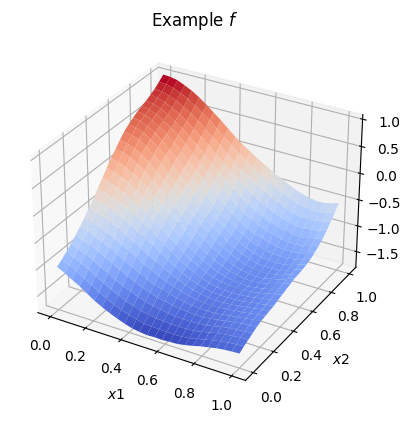

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})

x = jnp.linspace(0, 1, args['n_data'])
x1, x2 = jnp.meshgrid(x, x)

ax.plot_surface(x1, x2, y_test.reshape(-1,args['n_data'],args['n_data'])[0], cmap=coolwarm)
ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_title("Example $f$")

### PriorVAE model

We define the PriorVAE model, optimizer, and initialize the parameters of the model randomly.

In [6]:
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
activation_fn = args["activation_fn"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations = args["num_iterations"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]

In [7]:
encoder = MLPEncoder(hidden_dim, latent_dim, activation_fn)
decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

### Train the model

Train the model and plot the train loss and the test loss.

In [8]:
trainer = VAETrainer(model, optimizer, loss=SquaredSumAndKL(vae_var=vae_var))
trainer.init_params(sample_y_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_data_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')


[    1] training loss: 61126.474, test loss: 540894.514
[   11] training loss: 41748.895, test loss: 399618.866
[   21] training loss: 32775.058, test loss: 346995.631
[   31] training loss: 29740.577, test loss: 299514.574
[   41] training loss: 25881.783, test loss: 238196.226
[   51] training loss: 20669.841, test loss: 178870.604
[   61] training loss: 15172.028, test loss: 141627.128
[   71] training loss: 12863.995, test loss: 122962.716
[   81] training loss: 10940.440, test loss: 114385.925
[   91] training loss: 10886.721, test loss: 110330.591
[  101] training loss: 10171.659, test loss: 106144.784
[  111] training loss: 9853.276, test loss: 100857.992
[  121] training loss: 9711.657, test loss: 95738.030
[  131] training loss: 9281.397, test loss: 90899.372
[  141] training loss: 8503.061, test loss: 84247.106
[  151] training loss: 8371.806, test loss: 80890.465
[  161] training loss: 7543.059, test loss: 76122.540
[  171] training loss: 7035.475, test loss: 71513.275
[  18

Text(0.5, 1.0, 'Test loss')

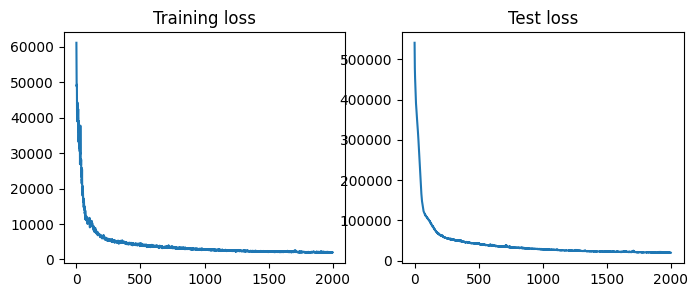

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample from the trained decoder model.

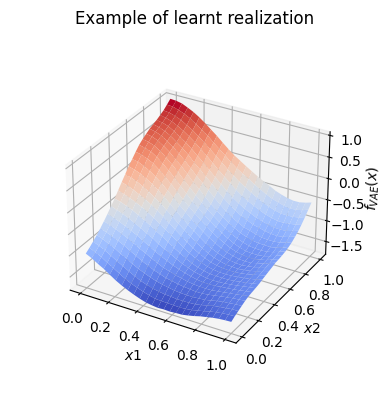

In [15]:
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
out = decoder.apply({'params': decoder_params}, z)             

x = jnp.linspace(0, 1, args['n_data'])
x1, x2 = jnp.meshgrid(x, x)

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})
ax.plot_surface(x1, x2, y_test.reshape(-1,args['n_data'],args['n_data'])[0], cmap=coolwarm)
ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$f_{VAE}(x)$')
ax.set_title("Example of learnt realization")
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()